In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
data = pd.read_csv('EuropeCovid2_data.csv', index_col=0)

In [5]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [6]:
data['id'].value_counts()

AT    180
BE    180
DK    180
FR    180
DE    180
IT    180
NO    180
ES    180
SE    180
CH    180
GB    180
Name: id, dtype: int64

In [7]:
region = 'GB'
data_r = data[data.id == region]
Y_raw = data_r.deaths.to_numpy()
POI = np.cumsum(Y_raw) > 0

In [8]:
POI[:int(np.sum(~POI) + np.sum(data_r.lockdown[POI]==0)/2)] = False
POI[int(POI.shape[0] - np.sum(data_r.lockdown[POI]==1)/2):] = False

In [9]:
# Y 
Y_data = Y_raw[POI]
I_data = data_r.cases[POI].to_numpy()

In [10]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

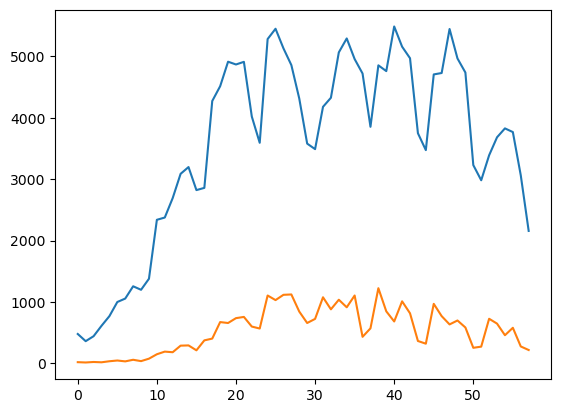

In [11]:
plt.plot(alpha*I_data)
plt.plot(Y_data)

In [12]:
GPi = np.load('EuropeCovid2_GPi.npz')

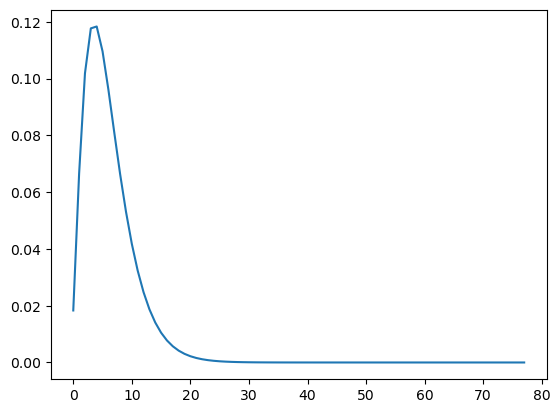

In [14]:
# g
g = np.zeros(T+T0)
g[:np.minimum(T+T0, GPi['g'].shape[0])] = GPi['g'][:np.minimum(T+T0, GPi['g'].shape[0])]
plt.plot(g)

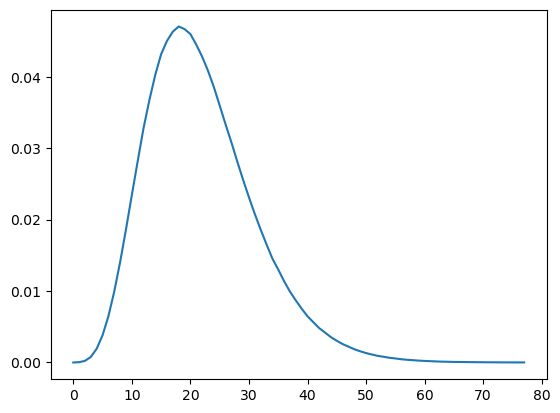

In [15]:
# pi
pi = np.zeros(T+T0)
pi[:np.minimum(T+T0, GPi['g'].shape[0])] = GPi['pi'][:np.minimum(T+T0, GPi['g'].shape[0])]
plt.plot(pi)

In [16]:
# A
d=2
A = np.zeros([T+T0, d])

In [17]:
A[:,0] = np.full(T+T0, 1)
A[T0:,1] = data_r.lockdown[POI].to_numpy()

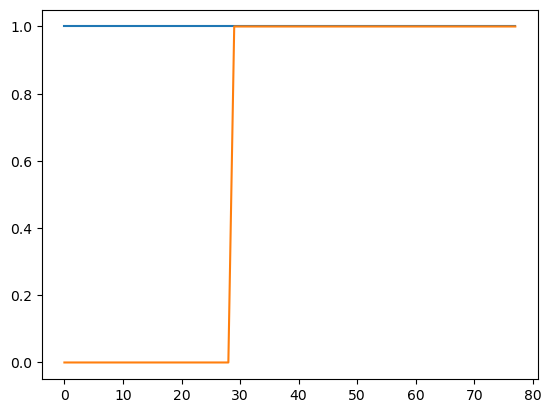

In [18]:
plt.plot(A)

# 3. fit by EM algorithm

In [19]:
def fit(obs, minit_0, sinit_eps, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    mhat_0=minit_0
    shat_eps = sinit_eps
    bhat=binit
    ss=np.inf
    
    # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
    
    if history:
        mhs_0 = np.zeros(n_iter)
        shs_eps = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
    if verbose:
        print("Before EM, shat_eps: %f"%shat_eps)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # iteration for mu
        mhat_0 = (obs @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2)
        # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
        
        # iteration for beta
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        EY = mhat_0 * Pi_inv_ImG[:,0]
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        d1f = - (2/(T+T0)/shat_eps**2) * d1EY @ (obs - EY)
        d2f = (2/(T+T0)/shat_eps**2) * (d1EY @ d1EY.T - d2EY @ (obs-EY))
        
        u, v = la.eig(d2f)
        db = np.real(((v/np.maximum(u,np.max(u)/100)) @ v.T) @ d1f)
        ss = np.min([ss, step_size/np.sqrt(np.sum(db**2))])
        bhat = bhat - ss * db
        
        for t in np.arange(T+T0):
            o = np.exp(bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = - K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
        if history:
            mhs_0[i] = mhat_0
            shs_eps[i] = shat_eps
            bhs[i] = bhat
        
        if verbose:
            print("%d-th iteration finished, shat_eps: %f, lapse: %.3fsec."
                  %(i+1, shat_eps, time.time()-start_iter))
            
    if history:
        return mhs_0, shs_eps, bhs
    else:
        return mhat_0, shat_eps, bhat

In [20]:
mmle_0 = 17.4
smle_eps = 138.5
bmle = [0.207, 1.872]

In [21]:
mhs_0, shs_eps, bhs =\
    fit(Y_data, mmle_0, smle_eps, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=0.05)

Before EM, shat_eps: 510.865760
1-th iteration finished, shat_eps: 173.216919, lapse: 0.002sec.
2-th iteration finished, shat_eps: 173.187716, lapse: 0.002sec.
3-th iteration finished, shat_eps: 173.186783, lapse: 0.002sec.
4-th iteration finished, shat_eps: 173.186157, lapse: 0.003sec.
5-th iteration finished, shat_eps: 173.185535, lapse: 0.002sec.
6-th iteration finished, shat_eps: 173.184916, lapse: 0.001sec.
7-th iteration finished, shat_eps: 173.184299, lapse: 0.001sec.
8-th iteration finished, shat_eps: 173.183683, lapse: 0.039sec.
9-th iteration finished, shat_eps: 173.183070, lapse: 0.004sec.
10-th iteration finished, shat_eps: 173.182458, lapse: 0.002sec.
11-th iteration finished, shat_eps: 173.181849, lapse: 0.003sec.
12-th iteration finished, shat_eps: 173.181241, lapse: 0.001sec.
13-th iteration finished, shat_eps: 173.180635, lapse: 0.001sec.
14-th iteration finished, shat_eps: 173.180032, lapse: 0.003sec.
15-th iteration finished, shat_eps: 173.179430, lapse: 0.001sec.
16

236-th iteration finished, shat_eps: 173.082991, lapse: 0.002sec.
237-th iteration finished, shat_eps: 173.082683, lapse: 0.020sec.
238-th iteration finished, shat_eps: 173.082376, lapse: 0.001sec.
239-th iteration finished, shat_eps: 173.082070, lapse: 0.002sec.
240-th iteration finished, shat_eps: 173.081764, lapse: 0.001sec.
241-th iteration finished, shat_eps: 173.081460, lapse: 0.001sec.
242-th iteration finished, shat_eps: 173.081156, lapse: 0.001sec.
243-th iteration finished, shat_eps: 173.080854, lapse: 0.001sec.
244-th iteration finished, shat_eps: 173.080552, lapse: 0.001sec.
245-th iteration finished, shat_eps: 173.080251, lapse: 0.001sec.
246-th iteration finished, shat_eps: 173.079951, lapse: 0.003sec.
247-th iteration finished, shat_eps: 173.079652, lapse: 0.002sec.
248-th iteration finished, shat_eps: 173.079354, lapse: 0.002sec.
249-th iteration finished, shat_eps: 173.079056, lapse: 0.002sec.
250-th iteration finished, shat_eps: 173.078760, lapse: 0.003sec.
251-th ite

375-th iteration finished, shat_eps: 173.047609, lapse: 0.004sec.
376-th iteration finished, shat_eps: 173.047401, lapse: 0.003sec.
377-th iteration finished, shat_eps: 173.047194, lapse: 0.002sec.
378-th iteration finished, shat_eps: 173.046988, lapse: 0.004sec.
379-th iteration finished, shat_eps: 173.046782, lapse: 0.011sec.
380-th iteration finished, shat_eps: 173.046576, lapse: 0.003sec.
381-th iteration finished, shat_eps: 173.046371, lapse: 0.001sec.
382-th iteration finished, shat_eps: 173.046167, lapse: 0.001sec.
383-th iteration finished, shat_eps: 173.045963, lapse: 0.003sec.
384-th iteration finished, shat_eps: 173.045760, lapse: 0.002sec.
385-th iteration finished, shat_eps: 173.045558, lapse: 0.001sec.
386-th iteration finished, shat_eps: 173.045356, lapse: 0.005sec.
387-th iteration finished, shat_eps: 173.045154, lapse: 0.003sec.
388-th iteration finished, shat_eps: 173.044953, lapse: 0.001sec.
389-th iteration finished, shat_eps: 173.044753, lapse: 0.001sec.
390-th ite

589-th iteration finished, shat_eps: 173.013886, lapse: 0.008sec.
590-th iteration finished, shat_eps: 173.013769, lapse: 0.002sec.
591-th iteration finished, shat_eps: 173.013653, lapse: 0.003sec.
592-th iteration finished, shat_eps: 173.013537, lapse: 0.003sec.
593-th iteration finished, shat_eps: 173.013421, lapse: 0.004sec.
594-th iteration finished, shat_eps: 173.013306, lapse: 0.004sec.
595-th iteration finished, shat_eps: 173.013191, lapse: 0.001sec.
596-th iteration finished, shat_eps: 173.013076, lapse: 0.002sec.
597-th iteration finished, shat_eps: 173.012962, lapse: 0.002sec.
598-th iteration finished, shat_eps: 173.012848, lapse: 0.003sec.
599-th iteration finished, shat_eps: 173.012734, lapse: 0.004sec.
600-th iteration finished, shat_eps: 173.012621, lapse: 0.007sec.
601-th iteration finished, shat_eps: 173.012507, lapse: 0.006sec.
602-th iteration finished, shat_eps: 173.012394, lapse: 0.001sec.
603-th iteration finished, shat_eps: 173.012282, lapse: 0.008sec.
604-th ite

810-th iteration finished, shat_eps: 172.994269, lapse: 0.004sec.
811-th iteration finished, shat_eps: 172.994203, lapse: 0.002sec.
812-th iteration finished, shat_eps: 172.994137, lapse: 0.012sec.
813-th iteration finished, shat_eps: 172.994071, lapse: 0.002sec.
814-th iteration finished, shat_eps: 172.994006, lapse: 0.002sec.
815-th iteration finished, shat_eps: 172.993941, lapse: 0.013sec.
816-th iteration finished, shat_eps: 172.993876, lapse: 0.002sec.
817-th iteration finished, shat_eps: 172.993811, lapse: 0.002sec.
818-th iteration finished, shat_eps: 172.993746, lapse: 0.003sec.
819-th iteration finished, shat_eps: 172.993682, lapse: 0.003sec.
820-th iteration finished, shat_eps: 172.993617, lapse: 0.001sec.
821-th iteration finished, shat_eps: 172.993553, lapse: 0.001sec.
822-th iteration finished, shat_eps: 172.993489, lapse: 0.001sec.
823-th iteration finished, shat_eps: 172.993425, lapse: 0.001sec.
824-th iteration finished, shat_eps: 172.993361, lapse: 0.003sec.
825-th ite

943-th iteration finished, shat_eps: 172.986812, lapse: 0.009sec.
944-th iteration finished, shat_eps: 172.986764, lapse: 0.003sec.
945-th iteration finished, shat_eps: 172.986717, lapse: 0.002sec.
946-th iteration finished, shat_eps: 172.986670, lapse: 0.002sec.
947-th iteration finished, shat_eps: 172.986624, lapse: 0.002sec.
948-th iteration finished, shat_eps: 172.986577, lapse: 0.001sec.
949-th iteration finished, shat_eps: 172.986530, lapse: 0.002sec.
950-th iteration finished, shat_eps: 172.986484, lapse: 0.001sec.
951-th iteration finished, shat_eps: 172.986437, lapse: 0.001sec.
952-th iteration finished, shat_eps: 172.986391, lapse: 0.001sec.
953-th iteration finished, shat_eps: 172.986345, lapse: 0.001sec.
954-th iteration finished, shat_eps: 172.986299, lapse: 0.001sec.
955-th iteration finished, shat_eps: 172.986253, lapse: 0.002sec.
956-th iteration finished, shat_eps: 172.986207, lapse: 0.004sec.
957-th iteration finished, shat_eps: 172.986161, lapse: 0.001sec.
958-th ite

1089-th iteration finished, shat_eps: 172.981018, lapse: 0.002sec.
1090-th iteration finished, shat_eps: 172.980985, lapse: 0.012sec.
1091-th iteration finished, shat_eps: 172.980952, lapse: 0.002sec.
1092-th iteration finished, shat_eps: 172.980919, lapse: 0.001sec.
1093-th iteration finished, shat_eps: 172.980887, lapse: 0.001sec.
1094-th iteration finished, shat_eps: 172.980854, lapse: 0.001sec.
1095-th iteration finished, shat_eps: 172.980822, lapse: 0.002sec.
1096-th iteration finished, shat_eps: 172.980789, lapse: 0.001sec.
1097-th iteration finished, shat_eps: 172.980757, lapse: 0.001sec.
1098-th iteration finished, shat_eps: 172.980724, lapse: 0.001sec.
1099-th iteration finished, shat_eps: 172.980692, lapse: 0.001sec.
1100-th iteration finished, shat_eps: 172.980660, lapse: 0.001sec.
1101-th iteration finished, shat_eps: 172.980628, lapse: 0.002sec.
1102-th iteration finished, shat_eps: 172.980596, lapse: 0.002sec.
1103-th iteration finished, shat_eps: 172.980564, lapse: 0.002

1226-th iteration finished, shat_eps: 172.977173, lapse: 0.002sec.
1227-th iteration finished, shat_eps: 172.977149, lapse: 0.021sec.
1228-th iteration finished, shat_eps: 172.977126, lapse: 0.001sec.
1229-th iteration finished, shat_eps: 172.977102, lapse: 0.002sec.
1230-th iteration finished, shat_eps: 172.977079, lapse: 0.001sec.
1231-th iteration finished, shat_eps: 172.977055, lapse: 0.001sec.
1232-th iteration finished, shat_eps: 172.977032, lapse: 0.001sec.
1233-th iteration finished, shat_eps: 172.977008, lapse: 0.003sec.
1234-th iteration finished, shat_eps: 172.976985, lapse: 0.002sec.
1235-th iteration finished, shat_eps: 172.976962, lapse: 0.001sec.
1236-th iteration finished, shat_eps: 172.976939, lapse: 0.001sec.
1237-th iteration finished, shat_eps: 172.976916, lapse: 0.001sec.
1238-th iteration finished, shat_eps: 172.976893, lapse: 0.001sec.
1239-th iteration finished, shat_eps: 172.976870, lapse: 0.001sec.
1240-th iteration finished, shat_eps: 172.976847, lapse: 0.001

1365-th iteration finished, shat_eps: 172.974374, lapse: 0.003sec.
1366-th iteration finished, shat_eps: 172.974357, lapse: 0.002sec.
1367-th iteration finished, shat_eps: 172.974340, lapse: 0.002sec.
1368-th iteration finished, shat_eps: 172.974323, lapse: 0.002sec.
1369-th iteration finished, shat_eps: 172.974306, lapse: 0.009sec.
1370-th iteration finished, shat_eps: 172.974290, lapse: 0.002sec.
1371-th iteration finished, shat_eps: 172.974273, lapse: 0.002sec.
1372-th iteration finished, shat_eps: 172.974256, lapse: 0.002sec.
1373-th iteration finished, shat_eps: 172.974239, lapse: 0.002sec.
1374-th iteration finished, shat_eps: 172.974223, lapse: 0.005sec.
1375-th iteration finished, shat_eps: 172.974206, lapse: 0.002sec.
1376-th iteration finished, shat_eps: 172.974190, lapse: 0.001sec.
1377-th iteration finished, shat_eps: 172.974173, lapse: 0.001sec.
1378-th iteration finished, shat_eps: 172.974157, lapse: 0.001sec.
1379-th iteration finished, shat_eps: 172.974140, lapse: 0.001

1492-th iteration finished, shat_eps: 172.972512, lapse: 0.002sec.
1493-th iteration finished, shat_eps: 172.972499, lapse: 0.002sec.
1494-th iteration finished, shat_eps: 172.972487, lapse: 0.002sec.
1495-th iteration finished, shat_eps: 172.972474, lapse: 0.002sec.
1496-th iteration finished, shat_eps: 172.972462, lapse: 0.002sec.
1497-th iteration finished, shat_eps: 172.972449, lapse: 0.002sec.
1498-th iteration finished, shat_eps: 172.972437, lapse: 0.009sec.
1499-th iteration finished, shat_eps: 172.972424, lapse: 0.002sec.
1500-th iteration finished, shat_eps: 172.972412, lapse: 0.002sec.
1501-th iteration finished, shat_eps: 172.972400, lapse: 0.001sec.
1502-th iteration finished, shat_eps: 172.972388, lapse: 0.001sec.
1503-th iteration finished, shat_eps: 172.972375, lapse: 0.001sec.
1504-th iteration finished, shat_eps: 172.972363, lapse: 0.002sec.
1505-th iteration finished, shat_eps: 172.972351, lapse: 0.005sec.
1506-th iteration finished, shat_eps: 172.972339, lapse: 0.002

1745-th iteration finished, shat_eps: 172.970112, lapse: 0.049sec.
1746-th iteration finished, shat_eps: 172.970105, lapse: 0.003sec.
1747-th iteration finished, shat_eps: 172.970098, lapse: 0.004sec.
1748-th iteration finished, shat_eps: 172.970091, lapse: 0.001sec.
1749-th iteration finished, shat_eps: 172.970084, lapse: 0.001sec.
1750-th iteration finished, shat_eps: 172.970078, lapse: 0.001sec.
1751-th iteration finished, shat_eps: 172.970071, lapse: 0.004sec.
1752-th iteration finished, shat_eps: 172.970064, lapse: 0.002sec.
1753-th iteration finished, shat_eps: 172.970057, lapse: 0.001sec.
1754-th iteration finished, shat_eps: 172.970050, lapse: 0.001sec.
1755-th iteration finished, shat_eps: 172.970043, lapse: 0.002sec.
1756-th iteration finished, shat_eps: 172.970037, lapse: 0.001sec.
1757-th iteration finished, shat_eps: 172.970030, lapse: 0.003sec.
1758-th iteration finished, shat_eps: 172.970023, lapse: 0.002sec.
1759-th iteration finished, shat_eps: 172.970016, lapse: 0.001

1876-th iteration finished, shat_eps: 172.969326, lapse: 0.011sec.
1877-th iteration finished, shat_eps: 172.969320, lapse: 0.003sec.
1878-th iteration finished, shat_eps: 172.969315, lapse: 0.003sec.
1879-th iteration finished, shat_eps: 172.969310, lapse: 0.002sec.
1880-th iteration finished, shat_eps: 172.969305, lapse: 0.002sec.
1881-th iteration finished, shat_eps: 172.969300, lapse: 0.002sec.
1882-th iteration finished, shat_eps: 172.969295, lapse: 0.001sec.
1883-th iteration finished, shat_eps: 172.969290, lapse: 0.001sec.
1884-th iteration finished, shat_eps: 172.969285, lapse: 0.001sec.
1885-th iteration finished, shat_eps: 172.969280, lapse: 0.001sec.
1886-th iteration finished, shat_eps: 172.969275, lapse: 0.001sec.
1887-th iteration finished, shat_eps: 172.969270, lapse: 0.001sec.
1888-th iteration finished, shat_eps: 172.969265, lapse: 0.001sec.
1889-th iteration finished, shat_eps: 172.969260, lapse: 0.001sec.
1890-th iteration finished, shat_eps: 172.969255, lapse: 0.001

2016-th iteration finished, shat_eps: 172.968710, lapse: 0.003sec.
2017-th iteration finished, shat_eps: 172.968706, lapse: 0.002sec.
2018-th iteration finished, shat_eps: 172.968703, lapse: 0.012sec.
2019-th iteration finished, shat_eps: 172.968699, lapse: 0.002sec.
2020-th iteration finished, shat_eps: 172.968695, lapse: 0.002sec.
2021-th iteration finished, shat_eps: 172.968692, lapse: 0.003sec.
2022-th iteration finished, shat_eps: 172.968688, lapse: 0.002sec.
2023-th iteration finished, shat_eps: 172.968684, lapse: 0.012sec.
2024-th iteration finished, shat_eps: 172.968681, lapse: 0.002sec.
2025-th iteration finished, shat_eps: 172.968677, lapse: 0.001sec.
2026-th iteration finished, shat_eps: 172.968673, lapse: 0.001sec.
2027-th iteration finished, shat_eps: 172.968670, lapse: 0.001sec.
2028-th iteration finished, shat_eps: 172.968666, lapse: 0.006sec.
2029-th iteration finished, shat_eps: 172.968662, lapse: 0.006sec.
2030-th iteration finished, shat_eps: 172.968659, lapse: 0.004

2241-th iteration finished, shat_eps: 172.968055, lapse: 0.010sec.
2242-th iteration finished, shat_eps: 172.968053, lapse: 0.004sec.
2243-th iteration finished, shat_eps: 172.968050, lapse: 0.002sec.
2244-th iteration finished, shat_eps: 172.968048, lapse: 0.003sec.
2245-th iteration finished, shat_eps: 172.968046, lapse: 0.003sec.
2246-th iteration finished, shat_eps: 172.968044, lapse: 0.001sec.
2247-th iteration finished, shat_eps: 172.968042, lapse: 0.001sec.
2248-th iteration finished, shat_eps: 172.968039, lapse: 0.001sec.
2249-th iteration finished, shat_eps: 172.968037, lapse: 0.001sec.
2250-th iteration finished, shat_eps: 172.968035, lapse: 0.002sec.
2251-th iteration finished, shat_eps: 172.968033, lapse: 0.002sec.
2252-th iteration finished, shat_eps: 172.968031, lapse: 0.002sec.
2253-th iteration finished, shat_eps: 172.968028, lapse: 0.003sec.
2254-th iteration finished, shat_eps: 172.968026, lapse: 0.002sec.
2255-th iteration finished, shat_eps: 172.968024, lapse: 0.002

2383-th iteration finished, shat_eps: 172.967784, lapse: 0.002sec.
2384-th iteration finished, shat_eps: 172.967783, lapse: 0.010sec.
2385-th iteration finished, shat_eps: 172.967781, lapse: 0.006sec.
2386-th iteration finished, shat_eps: 172.967779, lapse: 0.001sec.
2387-th iteration finished, shat_eps: 172.967778, lapse: 0.001sec.
2388-th iteration finished, shat_eps: 172.967776, lapse: 0.001sec.
2389-th iteration finished, shat_eps: 172.967775, lapse: 0.001sec.
2390-th iteration finished, shat_eps: 172.967773, lapse: 0.004sec.
2391-th iteration finished, shat_eps: 172.967772, lapse: 0.002sec.
2392-th iteration finished, shat_eps: 172.967770, lapse: 0.002sec.
2393-th iteration finished, shat_eps: 172.967768, lapse: 0.002sec.
2394-th iteration finished, shat_eps: 172.967767, lapse: 0.001sec.
2395-th iteration finished, shat_eps: 172.967765, lapse: 0.001sec.
2396-th iteration finished, shat_eps: 172.967764, lapse: 0.001sec.
2397-th iteration finished, shat_eps: 172.967762, lapse: 0.001

2628-th iteration finished, shat_eps: 172.967481, lapse: 0.040sec.
2629-th iteration finished, shat_eps: 172.967480, lapse: 0.002sec.
2630-th iteration finished, shat_eps: 172.967479, lapse: 0.013sec.
2631-th iteration finished, shat_eps: 172.967478, lapse: 0.001sec.
2632-th iteration finished, shat_eps: 172.967477, lapse: 0.001sec.
2633-th iteration finished, shat_eps: 172.967476, lapse: 0.001sec.
2634-th iteration finished, shat_eps: 172.967475, lapse: 0.001sec.
2635-th iteration finished, shat_eps: 172.967474, lapse: 0.001sec.
2636-th iteration finished, shat_eps: 172.967473, lapse: 0.002sec.
2637-th iteration finished, shat_eps: 172.967472, lapse: 0.002sec.
2638-th iteration finished, shat_eps: 172.967472, lapse: 0.007sec.
2639-th iteration finished, shat_eps: 172.967471, lapse: 0.002sec.
2640-th iteration finished, shat_eps: 172.967470, lapse: 0.001sec.
2641-th iteration finished, shat_eps: 172.967469, lapse: 0.001sec.
2642-th iteration finished, shat_eps: 172.967468, lapse: 0.001

2878-th iteration finished, shat_eps: 172.967303, lapse: 0.003sec.
2879-th iteration finished, shat_eps: 172.967303, lapse: 0.010sec.
2880-th iteration finished, shat_eps: 172.967302, lapse: 0.002sec.
2881-th iteration finished, shat_eps: 172.967302, lapse: 0.003sec.
2882-th iteration finished, shat_eps: 172.967301, lapse: 0.002sec.
2883-th iteration finished, shat_eps: 172.967301, lapse: 0.001sec.
2884-th iteration finished, shat_eps: 172.967300, lapse: 0.001sec.
2885-th iteration finished, shat_eps: 172.967300, lapse: 0.001sec.
2886-th iteration finished, shat_eps: 172.967299, lapse: 0.002sec.
2887-th iteration finished, shat_eps: 172.967299, lapse: 0.004sec.
2888-th iteration finished, shat_eps: 172.967298, lapse: 0.001sec.
2889-th iteration finished, shat_eps: 172.967298, lapse: 0.001sec.
2890-th iteration finished, shat_eps: 172.967297, lapse: 0.001sec.
2891-th iteration finished, shat_eps: 172.967297, lapse: 0.001sec.
2892-th iteration finished, shat_eps: 172.967296, lapse: 0.001

3063-th iteration finished, shat_eps: 172.967223, lapse: 0.003sec.
3064-th iteration finished, shat_eps: 172.967223, lapse: 0.005sec.
3065-th iteration finished, shat_eps: 172.967223, lapse: 0.003sec.
3066-th iteration finished, shat_eps: 172.967222, lapse: 0.002sec.
3067-th iteration finished, shat_eps: 172.967222, lapse: 0.003sec.
3068-th iteration finished, shat_eps: 172.967222, lapse: 0.002sec.
3069-th iteration finished, shat_eps: 172.967221, lapse: 0.002sec.
3070-th iteration finished, shat_eps: 172.967221, lapse: 0.002sec.
3071-th iteration finished, shat_eps: 172.967221, lapse: 0.002sec.
3072-th iteration finished, shat_eps: 172.967220, lapse: 0.001sec.
3073-th iteration finished, shat_eps: 172.967220, lapse: 0.001sec.
3074-th iteration finished, shat_eps: 172.967220, lapse: 0.001sec.
3075-th iteration finished, shat_eps: 172.967219, lapse: 0.001sec.
3076-th iteration finished, shat_eps: 172.967219, lapse: 0.001sec.
3077-th iteration finished, shat_eps: 172.967219, lapse: 0.001

3198-th iteration finished, shat_eps: 172.967183, lapse: 0.006sec.
3199-th iteration finished, shat_eps: 172.967182, lapse: 0.003sec.
3200-th iteration finished, shat_eps: 172.967182, lapse: 0.002sec.
3201-th iteration finished, shat_eps: 172.967182, lapse: 0.004sec.
3202-th iteration finished, shat_eps: 172.967182, lapse: 0.003sec.
3203-th iteration finished, shat_eps: 172.967181, lapse: 0.004sec.
3204-th iteration finished, shat_eps: 172.967181, lapse: 0.001sec.
3205-th iteration finished, shat_eps: 172.967181, lapse: 0.002sec.
3206-th iteration finished, shat_eps: 172.967181, lapse: 0.005sec.
3207-th iteration finished, shat_eps: 172.967180, lapse: 0.002sec.
3208-th iteration finished, shat_eps: 172.967180, lapse: 0.002sec.
3209-th iteration finished, shat_eps: 172.967180, lapse: 0.002sec.
3210-th iteration finished, shat_eps: 172.967180, lapse: 0.001sec.
3211-th iteration finished, shat_eps: 172.967179, lapse: 0.002sec.
3212-th iteration finished, shat_eps: 172.967179, lapse: 0.001

3329-th iteration finished, shat_eps: 172.967153, lapse: 0.010sec.
3330-th iteration finished, shat_eps: 172.967153, lapse: 0.006sec.
3331-th iteration finished, shat_eps: 172.967153, lapse: 0.002sec.
3332-th iteration finished, shat_eps: 172.967153, lapse: 0.002sec.
3333-th iteration finished, shat_eps: 172.967153, lapse: 0.001sec.
3334-th iteration finished, shat_eps: 172.967152, lapse: 0.001sec.
3335-th iteration finished, shat_eps: 172.967152, lapse: 0.001sec.
3336-th iteration finished, shat_eps: 172.967152, lapse: 0.001sec.
3337-th iteration finished, shat_eps: 172.967152, lapse: 0.001sec.
3338-th iteration finished, shat_eps: 172.967152, lapse: 0.003sec.
3339-th iteration finished, shat_eps: 172.967151, lapse: 0.001sec.
3340-th iteration finished, shat_eps: 172.967151, lapse: 0.002sec.
3341-th iteration finished, shat_eps: 172.967151, lapse: 0.001sec.
3342-th iteration finished, shat_eps: 172.967151, lapse: 0.001sec.
3343-th iteration finished, shat_eps: 172.967151, lapse: 0.001

3479-th iteration finished, shat_eps: 172.967129, lapse: 0.003sec.
3480-th iteration finished, shat_eps: 172.967129, lapse: 0.002sec.
3481-th iteration finished, shat_eps: 172.967129, lapse: 0.002sec.
3482-th iteration finished, shat_eps: 172.967128, lapse: 0.002sec.
3483-th iteration finished, shat_eps: 172.967128, lapse: 0.002sec.
3484-th iteration finished, shat_eps: 172.967128, lapse: 0.002sec.
3485-th iteration finished, shat_eps: 172.967128, lapse: 0.002sec.
3486-th iteration finished, shat_eps: 172.967128, lapse: 0.002sec.
3487-th iteration finished, shat_eps: 172.967128, lapse: 0.001sec.
3488-th iteration finished, shat_eps: 172.967128, lapse: 0.001sec.
3489-th iteration finished, shat_eps: 172.967128, lapse: 0.001sec.
3490-th iteration finished, shat_eps: 172.967127, lapse: 0.011sec.
3491-th iteration finished, shat_eps: 172.967127, lapse: 0.002sec.
3492-th iteration finished, shat_eps: 172.967127, lapse: 0.002sec.
3493-th iteration finished, shat_eps: 172.967127, lapse: 0.002

3628-th iteration finished, shat_eps: 172.967111, lapse: 0.003sec.
3629-th iteration finished, shat_eps: 172.967111, lapse: 0.002sec.
3630-th iteration finished, shat_eps: 172.967111, lapse: 0.002sec.
3631-th iteration finished, shat_eps: 172.967111, lapse: 0.002sec.
3632-th iteration finished, shat_eps: 172.967111, lapse: 0.002sec.
3633-th iteration finished, shat_eps: 172.967111, lapse: 0.020sec.
3634-th iteration finished, shat_eps: 172.967111, lapse: 0.002sec.
3635-th iteration finished, shat_eps: 172.967111, lapse: 0.002sec.
3636-th iteration finished, shat_eps: 172.967111, lapse: 0.002sec.
3637-th iteration finished, shat_eps: 172.967111, lapse: 0.001sec.
3638-th iteration finished, shat_eps: 172.967110, lapse: 0.001sec.
3639-th iteration finished, shat_eps: 172.967110, lapse: 0.003sec.
3640-th iteration finished, shat_eps: 172.967110, lapse: 0.007sec.
3641-th iteration finished, shat_eps: 172.967110, lapse: 0.001sec.
3642-th iteration finished, shat_eps: 172.967110, lapse: 0.003

3767-th iteration finished, shat_eps: 172.967100, lapse: 0.002sec.
3768-th iteration finished, shat_eps: 172.967100, lapse: 0.002sec.
3769-th iteration finished, shat_eps: 172.967099, lapse: 0.002sec.
3770-th iteration finished, shat_eps: 172.967099, lapse: 0.002sec.
3771-th iteration finished, shat_eps: 172.967099, lapse: 0.002sec.
3772-th iteration finished, shat_eps: 172.967099, lapse: 0.010sec.
3773-th iteration finished, shat_eps: 172.967099, lapse: 0.002sec.
3774-th iteration finished, shat_eps: 172.967099, lapse: 0.002sec.
3775-th iteration finished, shat_eps: 172.967099, lapse: 0.002sec.
3776-th iteration finished, shat_eps: 172.967099, lapse: 0.002sec.
3777-th iteration finished, shat_eps: 172.967099, lapse: 0.002sec.
3778-th iteration finished, shat_eps: 172.967099, lapse: 0.001sec.
3779-th iteration finished, shat_eps: 172.967099, lapse: 0.001sec.
3780-th iteration finished, shat_eps: 172.967099, lapse: 0.001sec.
3781-th iteration finished, shat_eps: 172.967099, lapse: 0.001

3985-th iteration finished, shat_eps: 172.967087, lapse: 0.003sec.
3986-th iteration finished, shat_eps: 172.967087, lapse: 0.009sec.
3987-th iteration finished, shat_eps: 172.967087, lapse: 0.001sec.
3988-th iteration finished, shat_eps: 172.967087, lapse: 0.002sec.
3989-th iteration finished, shat_eps: 172.967087, lapse: 0.002sec.
3990-th iteration finished, shat_eps: 172.967087, lapse: 0.004sec.
3991-th iteration finished, shat_eps: 172.967087, lapse: 0.003sec.
3992-th iteration finished, shat_eps: 172.967087, lapse: 0.007sec.
3993-th iteration finished, shat_eps: 172.967087, lapse: 0.002sec.
3994-th iteration finished, shat_eps: 172.967087, lapse: 0.002sec.
3995-th iteration finished, shat_eps: 172.967087, lapse: 0.002sec.
3996-th iteration finished, shat_eps: 172.967087, lapse: 0.005sec.
3997-th iteration finished, shat_eps: 172.967087, lapse: 0.001sec.
3998-th iteration finished, shat_eps: 172.967087, lapse: 0.003sec.
3999-th iteration finished, shat_eps: 172.967086, lapse: 0.002

4226-th iteration finished, shat_eps: 172.967079, lapse: 0.003sec.
4227-th iteration finished, shat_eps: 172.967079, lapse: 0.010sec.
4228-th iteration finished, shat_eps: 172.967079, lapse: 0.002sec.
4229-th iteration finished, shat_eps: 172.967079, lapse: 0.002sec.
4230-th iteration finished, shat_eps: 172.967079, lapse: 0.002sec.
4231-th iteration finished, shat_eps: 172.967079, lapse: 0.003sec.
4232-th iteration finished, shat_eps: 172.967079, lapse: 0.001sec.
4233-th iteration finished, shat_eps: 172.967079, lapse: 0.001sec.
4234-th iteration finished, shat_eps: 172.967079, lapse: 0.001sec.
4235-th iteration finished, shat_eps: 172.967079, lapse: 0.001sec.
4236-th iteration finished, shat_eps: 172.967079, lapse: 0.001sec.
4237-th iteration finished, shat_eps: 172.967079, lapse: 0.001sec.
4238-th iteration finished, shat_eps: 172.967078, lapse: 0.001sec.
4239-th iteration finished, shat_eps: 172.967078, lapse: 0.001sec.
4240-th iteration finished, shat_eps: 172.967078, lapse: 0.001

4367-th iteration finished, shat_eps: 172.967076, lapse: 0.006sec.
4368-th iteration finished, shat_eps: 172.967076, lapse: 0.013sec.
4369-th iteration finished, shat_eps: 172.967076, lapse: 0.003sec.
4370-th iteration finished, shat_eps: 172.967076, lapse: 0.002sec.
4371-th iteration finished, shat_eps: 172.967076, lapse: 0.002sec.
4372-th iteration finished, shat_eps: 172.967076, lapse: 0.002sec.
4373-th iteration finished, shat_eps: 172.967076, lapse: 0.002sec.
4374-th iteration finished, shat_eps: 172.967076, lapse: 0.002sec.
4375-th iteration finished, shat_eps: 172.967075, lapse: 0.001sec.
4376-th iteration finished, shat_eps: 172.967075, lapse: 0.001sec.
4377-th iteration finished, shat_eps: 172.967075, lapse: 0.001sec.
4378-th iteration finished, shat_eps: 172.967075, lapse: 0.001sec.
4379-th iteration finished, shat_eps: 172.967075, lapse: 0.001sec.
4380-th iteration finished, shat_eps: 172.967075, lapse: 0.001sec.
4381-th iteration finished, shat_eps: 172.967075, lapse: 0.001

4508-th iteration finished, shat_eps: 172.967073, lapse: 0.002sec.
4509-th iteration finished, shat_eps: 172.967073, lapse: 0.002sec.
4510-th iteration finished, shat_eps: 172.967073, lapse: 0.002sec.
4511-th iteration finished, shat_eps: 172.967073, lapse: 0.010sec.
4512-th iteration finished, shat_eps: 172.967073, lapse: 0.004sec.
4513-th iteration finished, shat_eps: 172.967073, lapse: 0.001sec.
4514-th iteration finished, shat_eps: 172.967073, lapse: 0.001sec.
4515-th iteration finished, shat_eps: 172.967073, lapse: 0.001sec.
4516-th iteration finished, shat_eps: 172.967073, lapse: 0.001sec.
4517-th iteration finished, shat_eps: 172.967073, lapse: 0.001sec.
4518-th iteration finished, shat_eps: 172.967073, lapse: 0.001sec.
4519-th iteration finished, shat_eps: 172.967073, lapse: 0.001sec.
4520-th iteration finished, shat_eps: 172.967073, lapse: 0.001sec.
4521-th iteration finished, shat_eps: 172.967073, lapse: 0.002sec.
4522-th iteration finished, shat_eps: 172.967073, lapse: 0.002

4645-th iteration finished, shat_eps: 172.967072, lapse: 0.002sec.
4646-th iteration finished, shat_eps: 172.967072, lapse: 0.002sec.
4647-th iteration finished, shat_eps: 172.967072, lapse: 0.009sec.
4648-th iteration finished, shat_eps: 172.967072, lapse: 0.001sec.
4649-th iteration finished, shat_eps: 172.967072, lapse: 0.001sec.
4650-th iteration finished, shat_eps: 172.967072, lapse: 0.001sec.
4651-th iteration finished, shat_eps: 172.967072, lapse: 0.001sec.
4652-th iteration finished, shat_eps: 172.967072, lapse: 0.001sec.
4653-th iteration finished, shat_eps: 172.967072, lapse: 0.001sec.
4654-th iteration finished, shat_eps: 172.967072, lapse: 0.001sec.
4655-th iteration finished, shat_eps: 172.967072, lapse: 0.001sec.
4656-th iteration finished, shat_eps: 172.967072, lapse: 0.002sec.
4657-th iteration finished, shat_eps: 172.967072, lapse: 0.002sec.
4658-th iteration finished, shat_eps: 172.967072, lapse: 0.002sec.
4659-th iteration finished, shat_eps: 172.967072, lapse: 0.002

4786-th iteration finished, shat_eps: 172.967070, lapse: 0.009sec.
4787-th iteration finished, shat_eps: 172.967070, lapse: 0.002sec.
4788-th iteration finished, shat_eps: 172.967070, lapse: 0.002sec.
4789-th iteration finished, shat_eps: 172.967070, lapse: 0.002sec.
4790-th iteration finished, shat_eps: 172.967070, lapse: 0.002sec.
4791-th iteration finished, shat_eps: 172.967070, lapse: 0.004sec.
4792-th iteration finished, shat_eps: 172.967070, lapse: 0.002sec.
4793-th iteration finished, shat_eps: 172.967070, lapse: 0.004sec.
4794-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4795-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4796-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4797-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4798-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4799-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4800-th iteration finished, shat_eps: 172.967070, lapse: 0.001

4921-th iteration finished, shat_eps: 172.967070, lapse: 0.002sec.
4922-th iteration finished, shat_eps: 172.967070, lapse: 0.002sec.
4923-th iteration finished, shat_eps: 172.967070, lapse: 0.009sec.
4924-th iteration finished, shat_eps: 172.967070, lapse: 0.002sec.
4925-th iteration finished, shat_eps: 172.967070, lapse: 0.003sec.
4926-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4927-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4928-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4929-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4930-th iteration finished, shat_eps: 172.967070, lapse: 0.003sec.
4931-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4932-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4933-th iteration finished, shat_eps: 172.967070, lapse: 0.001sec.
4934-th iteration finished, shat_eps: 172.967070, lapse: 0.002sec.
4935-th iteration finished, shat_eps: 172.967070, lapse: 0.002

5065-th iteration finished, shat_eps: 172.967069, lapse: 0.002sec.
5066-th iteration finished, shat_eps: 172.967069, lapse: 0.002sec.
5067-th iteration finished, shat_eps: 172.967069, lapse: 0.002sec.
5068-th iteration finished, shat_eps: 172.967069, lapse: 0.002sec.
5069-th iteration finished, shat_eps: 172.967069, lapse: 0.002sec.
5070-th iteration finished, shat_eps: 172.967069, lapse: 0.002sec.
5071-th iteration finished, shat_eps: 172.967069, lapse: 0.009sec.
5072-th iteration finished, shat_eps: 172.967069, lapse: 0.001sec.
5073-th iteration finished, shat_eps: 172.967069, lapse: 0.001sec.
5074-th iteration finished, shat_eps: 172.967069, lapse: 0.001sec.
5075-th iteration finished, shat_eps: 172.967069, lapse: 0.002sec.
5076-th iteration finished, shat_eps: 172.967069, lapse: 0.002sec.
5077-th iteration finished, shat_eps: 172.967069, lapse: 0.003sec.
5078-th iteration finished, shat_eps: 172.967069, lapse: 0.002sec.
5079-th iteration finished, shat_eps: 172.967069, lapse: 0.001

5212-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5213-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5214-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5215-th iteration finished, shat_eps: 172.967068, lapse: 0.009sec.
5216-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5217-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5218-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5219-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5220-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5221-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5222-th iteration finished, shat_eps: 172.967068, lapse: 0.006sec.
5223-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5224-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5225-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5226-th iteration finished, shat_eps: 172.967068, lapse: 0.001

5460-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5461-th iteration finished, shat_eps: 172.967068, lapse: 0.011sec.
5462-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5463-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5464-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5465-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5466-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5467-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5468-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5469-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5470-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5471-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5472-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5473-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5474-th iteration finished, shat_eps: 172.967068, lapse: 0.001

5650-th iteration finished, shat_eps: 172.967068, lapse: 0.003sec.
5651-th iteration finished, shat_eps: 172.967068, lapse: 0.006sec.
5652-th iteration finished, shat_eps: 172.967068, lapse: 0.003sec.
5653-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5654-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5655-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5656-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5657-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5658-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5659-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5660-th iteration finished, shat_eps: 172.967068, lapse: 0.002sec.
5661-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5662-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5663-th iteration finished, shat_eps: 172.967068, lapse: 0.001sec.
5664-th iteration finished, shat_eps: 172.967068, lapse: 0.001

5798-th iteration finished, shat_eps: 172.967067, lapse: 0.009sec.
5799-th iteration finished, shat_eps: 172.967067, lapse: 0.008sec.
5800-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5801-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5802-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5803-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5804-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5805-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5806-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5807-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
5808-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5809-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5810-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
5811-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5812-th iteration finished, shat_eps: 172.967067, lapse: 0.001

5944-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
5945-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
5946-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
5947-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
5948-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
5949-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
5950-th iteration finished, shat_eps: 172.967067, lapse: 0.008sec.
5951-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5952-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5953-th iteration finished, shat_eps: 172.967067, lapse: 0.011sec.
5954-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5955-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5956-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5957-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
5958-th iteration finished, shat_eps: 172.967067, lapse: 0.001

6081-th iteration finished, shat_eps: 172.967067, lapse: 0.009sec.
6082-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
6083-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6084-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6085-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6086-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6087-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6088-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6089-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6090-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6091-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6092-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6093-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6094-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6095-th iteration finished, shat_eps: 172.967067, lapse: 0.001

6316-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6317-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6318-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6319-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
6320-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6321-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
6322-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6323-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6324-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6325-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6326-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6327-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
6328-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6329-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6330-th iteration finished, shat_eps: 172.967067, lapse: 0.002

6570-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6571-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6572-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6573-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6574-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6575-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6576-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6577-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6578-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6579-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6580-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
6581-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6582-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
6583-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
6584-th iteration finished, shat_eps: 172.967067, lapse: 0.003

6702-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6703-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6704-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6705-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
6706-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6707-th iteration finished, shat_eps: 172.967067, lapse: 0.004sec.
6708-th iteration finished, shat_eps: 172.967067, lapse: 0.004sec.
6709-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
6710-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6711-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6712-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6713-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6714-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6715-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6716-th iteration finished, shat_eps: 172.967067, lapse: 0.001

6850-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6851-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
6852-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6853-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6854-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6855-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6856-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6857-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6858-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6859-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6860-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6861-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6862-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6863-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6864-th iteration finished, shat_eps: 172.967067, lapse: 0.002

6978-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6979-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6980-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6981-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6982-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6983-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
6984-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
6985-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6986-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
6987-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
6988-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
6989-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6990-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6991-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
6992-th iteration finished, shat_eps: 172.967067, lapse: 0.001

7110-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
7111-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7112-th iteration finished, shat_eps: 172.967067, lapse: 0.007sec.
7113-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7114-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7115-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
7116-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7117-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7118-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7119-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7120-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7121-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7122-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7123-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7124-th iteration finished, shat_eps: 172.967067, lapse: 0.002

7243-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7244-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7245-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7246-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7247-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
7248-th iteration finished, shat_eps: 172.967067, lapse: 0.008sec.
7249-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7250-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7251-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7252-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7253-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
7254-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7255-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7256-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7257-th iteration finished, shat_eps: 172.967067, lapse: 0.002

7450-th iteration finished, shat_eps: 172.967067, lapse: 0.007sec.
7451-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7452-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
7453-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
7454-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
7455-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7456-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7457-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7458-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7459-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7460-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7461-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7462-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7463-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7464-th iteration finished, shat_eps: 172.967067, lapse: 0.001

7600-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
7601-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
7602-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7603-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7604-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7605-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7606-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7607-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7608-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7609-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7610-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7611-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7612-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7613-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7614-th iteration finished, shat_eps: 172.967067, lapse: 0.001

7749-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7750-th iteration finished, shat_eps: 172.967067, lapse: 0.014sec.
7751-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7752-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7753-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7754-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7755-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7756-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7757-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7758-th iteration finished, shat_eps: 172.967067, lapse: 0.006sec.
7759-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7760-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7761-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7762-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7763-th iteration finished, shat_eps: 172.967067, lapse: 0.002

7884-th iteration finished, shat_eps: 172.967067, lapse: 0.004sec.
7885-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7886-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7887-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7888-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7889-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
7890-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7891-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7892-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7893-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7894-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7895-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7896-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
7897-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
7898-th iteration finished, shat_eps: 172.967067, lapse: 0.001

8026-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8027-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8028-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8029-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8030-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8031-th iteration finished, shat_eps: 172.967067, lapse: 0.009sec.
8032-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8033-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8034-th iteration finished, shat_eps: 172.967067, lapse: 0.008sec.
8035-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8036-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8037-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8038-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8039-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8040-th iteration finished, shat_eps: 172.967067, lapse: 0.001

8172-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8173-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8174-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8175-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8176-th iteration finished, shat_eps: 172.967067, lapse: 0.009sec.
8177-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8178-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8179-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8180-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8181-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8182-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8183-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8184-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8185-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8186-th iteration finished, shat_eps: 172.967067, lapse: 0.001

8296-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8297-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8298-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8299-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
8300-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8301-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8302-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8303-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8304-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8305-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8306-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8307-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8308-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8309-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8310-th iteration finished, shat_eps: 172.967067, lapse: 0.001

8437-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8438-th iteration finished, shat_eps: 172.967067, lapse: 0.011sec.
8439-th iteration finished, shat_eps: 172.967067, lapse: 0.005sec.
8440-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8441-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8442-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8443-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8444-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8445-th iteration finished, shat_eps: 172.967067, lapse: 0.004sec.
8446-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8447-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8448-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8449-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8450-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8451-th iteration finished, shat_eps: 172.967067, lapse: 0.001

8573-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8574-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8575-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8576-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
8577-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8578-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8579-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8580-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8581-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8582-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8583-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8584-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8585-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8586-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8587-th iteration finished, shat_eps: 172.967067, lapse: 0.001

8718-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8719-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8720-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8721-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8722-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8723-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8724-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8725-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8726-th iteration finished, shat_eps: 172.967067, lapse: 0.011sec.
8727-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8728-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8729-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8730-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8731-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8732-th iteration finished, shat_eps: 172.967067, lapse: 0.002

8843-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8844-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8845-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8846-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8847-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8848-th iteration finished, shat_eps: 172.967067, lapse: 0.009sec.
8849-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8850-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8851-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8852-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8853-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8854-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8855-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8856-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8857-th iteration finished, shat_eps: 172.967067, lapse: 0.002

8970-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
8971-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8972-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
8973-th iteration finished, shat_eps: 172.967067, lapse: 0.004sec.
8974-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8975-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8976-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8977-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8978-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8979-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8980-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
8981-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8982-th iteration finished, shat_eps: 172.967067, lapse: 0.005sec.
8983-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
8984-th iteration finished, shat_eps: 172.967067, lapse: 0.002

9103-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9104-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9105-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9106-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
9107-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9108-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9109-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9110-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9111-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9112-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9113-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9114-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9115-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9116-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9117-th iteration finished, shat_eps: 172.967067, lapse: 0.001

9252-th iteration finished, shat_eps: 172.967067, lapse: 0.011sec.
9253-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9254-th iteration finished, shat_eps: 172.967067, lapse: 0.005sec.
9255-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9256-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9257-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9258-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9259-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9260-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9261-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9262-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9263-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9264-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9265-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9266-th iteration finished, shat_eps: 172.967067, lapse: 0.002

9391-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9392-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9393-th iteration finished, shat_eps: 172.967067, lapse: 0.010sec.
9394-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9395-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9396-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9397-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9398-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9399-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9400-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9401-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
9402-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9403-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9404-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9405-th iteration finished, shat_eps: 172.967067, lapse: 0.001

9533-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9534-th iteration finished, shat_eps: 172.967067, lapse: 0.004sec.
9535-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9536-th iteration finished, shat_eps: 172.967067, lapse: 0.004sec.
9537-th iteration finished, shat_eps: 172.967067, lapse: 0.005sec.
9538-th iteration finished, shat_eps: 172.967067, lapse: 0.004sec.
9539-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9540-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9541-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
9542-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9543-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9544-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9545-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9546-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9547-th iteration finished, shat_eps: 172.967067, lapse: 0.002

9750-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
9751-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9752-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9753-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9754-th iteration finished, shat_eps: 172.967067, lapse: 0.009sec.
9755-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9756-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9757-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9758-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9759-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9760-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9761-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9762-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9763-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9764-th iteration finished, shat_eps: 172.967067, lapse: 0.001

9911-th iteration finished, shat_eps: 172.967067, lapse: 0.003sec.
9912-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9913-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9914-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9915-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9916-th iteration finished, shat_eps: 172.967067, lapse: 0.012sec.
9917-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9918-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9919-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9920-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9921-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9922-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9923-th iteration finished, shat_eps: 172.967067, lapse: 0.002sec.
9924-th iteration finished, shat_eps: 172.967067, lapse: 0.001sec.
9925-th iteration finished, shat_eps: 172.967067, lapse: 0.001

In [22]:
mmle_0 = mhs_0[-1]
smle_eps = shs_eps[-1]
bmle = bhs[-1]

In [23]:
mmle_0, smle_eps, bmle

(51.43779774180614, 172.96706707357055, array([0.05804858, 2.07869466]))

## plots

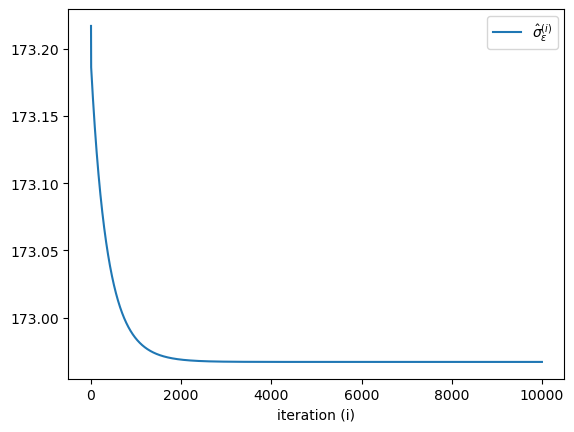

In [24]:
plt.plot(shs_eps, label=r"$\hat{\sigma}^{(i)}_\epsilon$")
plt.xlabel("iteration (i)"); plt.legend()

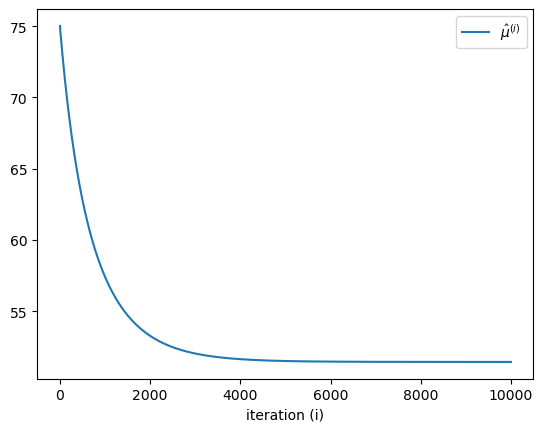

In [25]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

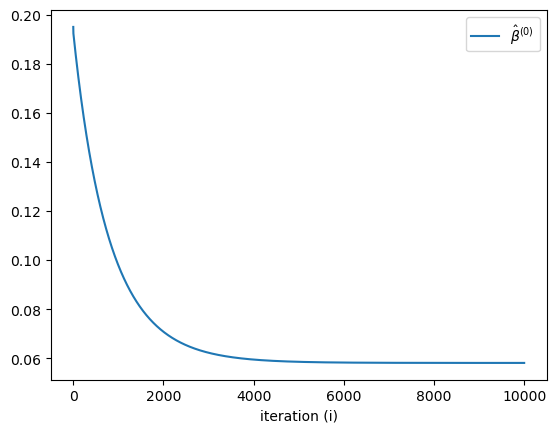

In [26]:
plt.plot(bhs[:,0], label=r"$\hat{\beta}^{(0)}$")
plt.xlabel("iteration (i)"); plt.legend()

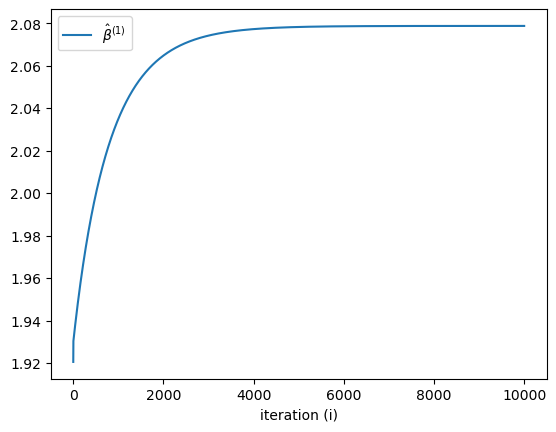

In [27]:
plt.plot(bhs[:,1], label=r"$\hat{\beta}^{(1)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Parametric bootstrap

In [28]:
num_sim = 100
n_iter = 10000

In [29]:
msim_0 = np.zeros([num_sim, n_iter])
ssim_eps = np.zeros([num_sim, n_iter])
bsim = np.zeros([num_sim, n_iter, d])

In [30]:
I_sim = np.zeros(T+T0)
Ys_sim = np.zeros([num_sim, T])

## simulation

In [31]:
mu_0 = mmle_0
s_eps = smle_eps
beta = bmle

In [32]:
R = np.zeros(T+T0)
for t in np.arange(T+T0):
    R[t] = K / (1 + np.exp(beta @ A[t]))

In [33]:
I_sim[0] = mu_0
for t in np.arange(1, T0):
    I_sim[t] = R[t] * np.sum(np.flip(I_sim[:t])*g[:t])
for t in np.arange(T0,T+T0):
    I_sim[t] = R[t] * np.sum(np.flip(I_sim[:t])*g[:t])

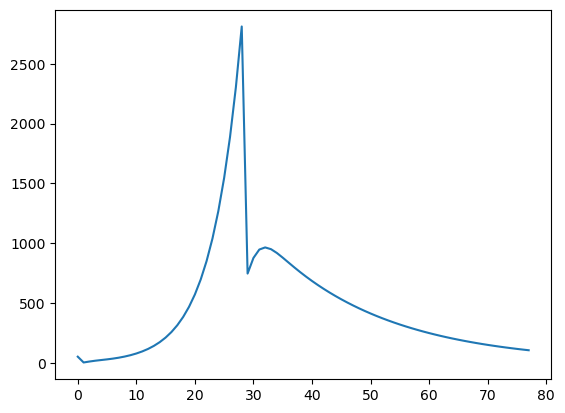

In [34]:
plt.plot(I_sim)

In [35]:
Y_sim = np.zeros([T])    
for t in np.arange(T):
    Y_sim[t] = alpha * np.sum(np.flip(I_sim[:t+T0])*pi[:t+T0]) + np.random.normal(0,s_eps)

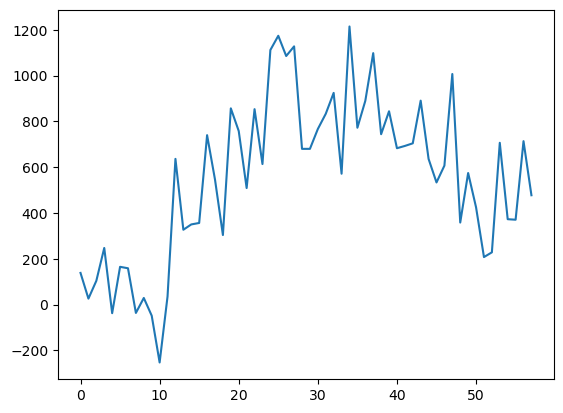

In [36]:
plt.plot(Y_sim)

In [37]:
mhat_0, shat_eps, bhat =\
    fit(Y_sim, minit_0 = mu_0, sinit_eps = s_eps,
        binit = beta, history=True, n_iter=n_iter, step_size=0.05) 

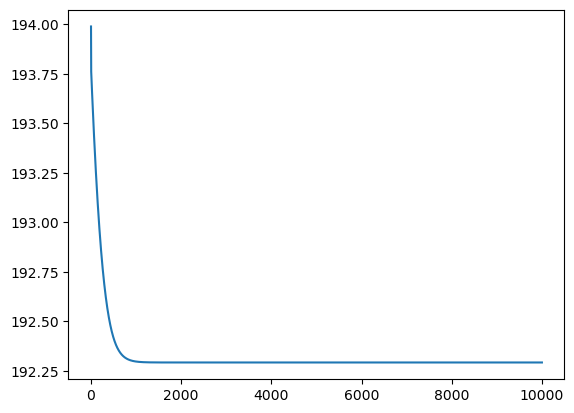

In [38]:
plt.plot(shat_eps)

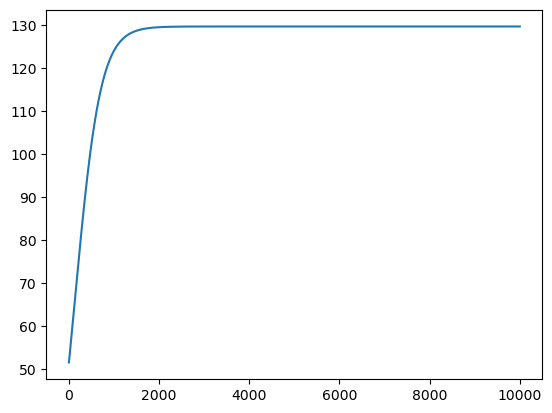

In [39]:
plt.plot(mhat_0)

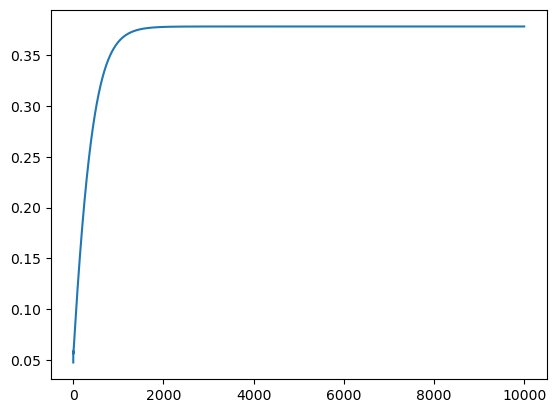

In [40]:
plt.plot(bhat[:,0])

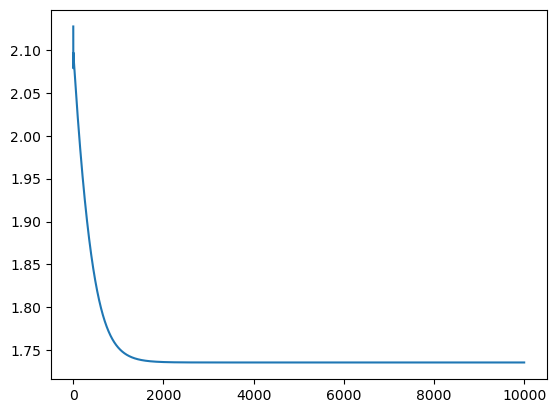

In [41]:
plt.plot(bhat[:,1])

## iteration

In [42]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    Y_sim = np.zeros([T])    
    for t in np.arange(T):
        Y_sim[t] = alpha * np.sum(np.flip(I_sim[:t+T0])*pi[:t+T0]) + np.random.normal(0,s_eps)
        
    mhat_0, shat_eps, bhat =\
        fit(Y_sim, minit_0 = mmle_0, sinit_eps = smle_eps,
            binit = bmle, history=True, n_iter=n_iter, step_size=0.05) 
    
    msim_0[iter_sim] = mhat_0
    ssim_eps[iter_sim] = shat_eps
    bsim[iter_sim] = bhat
    
    Ys_sim[iter_sim] = Y_sim
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 16.310546 sec.
2-th simulation finished, 19.329881 sec.
3-th simulation finished, 22.410253 sec.
4-th simulation finished, 16.854703 sec.
5-th simulation finished, 17.465521 sec.
6-th simulation finished, 16.341511 sec.
7-th simulation finished, 15.765205 sec.
8-th simulation finished, 16.483198 sec.
9-th simulation finished, 19.194893 sec.
10-th simulation finished, 16.966861 sec.
11-th simulation finished, 19.691881 sec.
12-th simulation finished, 19.542091 sec.
13-th simulation finished, 17.409882 sec.
14-th simulation finished, 19.261163 sec.
15-th simulation finished, 19.232341 sec.
16-th simulation finished, 21.480223 sec.
17-th simulation finished, 17.908831 sec.
18-th simulation finished, 16.639237 sec.
19-th simulation finished, 16.499848 sec.
20-th simulation finished, 16.092653 sec.
21-th simulation finished, 16.484552 sec.
22-th simulation finished, 16.724771 sec.
23-th simulation finished, 15.837257 sec.
24-th simulation finished, 16.465405 sec.
2

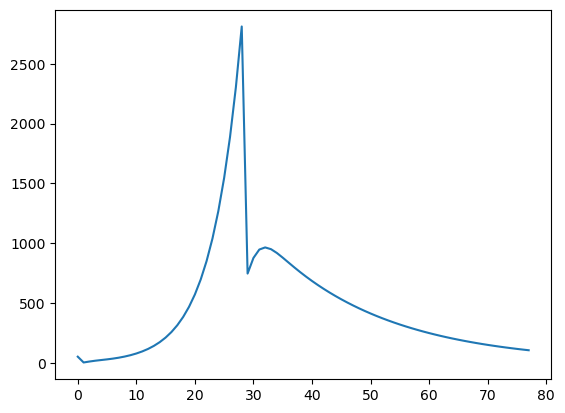

In [43]:
plt.plot(I_sim)

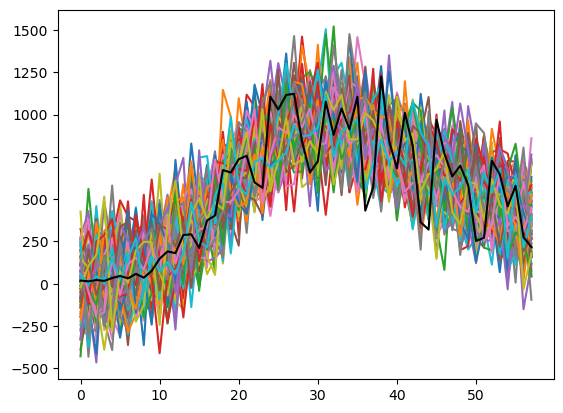

In [44]:
plt.plot(Ys_sim.T)
plt.plot(Y_data, color='black')
plt.show()

## plots

In [45]:
id_valid = (ssim_eps[:,0] - ssim_eps[:,-1] > 0)

(array([ 3.,  6.,  7.,  8., 17., 18., 17., 12.,  9.,  3.]),
 array([123.75962231, 131.58198236, 139.40434241, 147.22670246,
        155.04906251, 162.87142257, 170.69378262, 178.51614267,
        186.33850272, 194.16086277, 201.98322282]),
 <BarContainer object of 10 artists>)

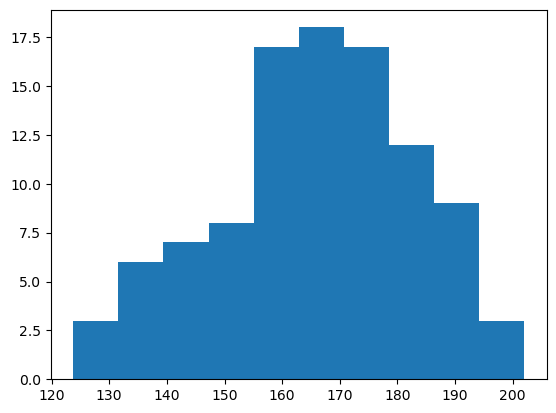

In [46]:
plt.hist(ssim_eps[id_valid,-1])

(array([27., 28., 20.,  5.,  5.,  4.,  5.,  4.,  0.,  2.]),
 array([  1.75327804,  31.03742235,  60.32156666,  89.60571097,
        118.88985528, 148.17399959, 177.4581439 , 206.74228821,
        236.02643252, 265.31057683, 294.59472114]),
 <BarContainer object of 10 artists>)

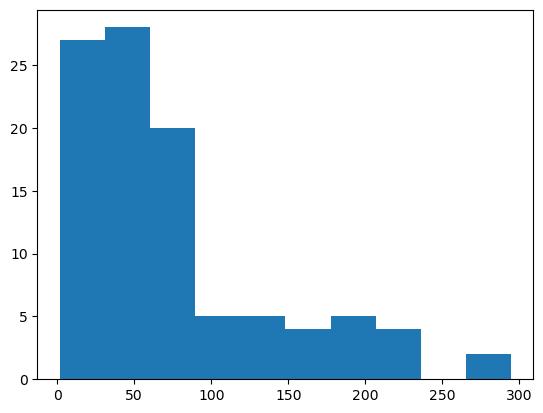

In [47]:
plt.hist(msim_0[id_valid,-1])

Text(0, 0.5, '$\\hat{\\beta}_1$')

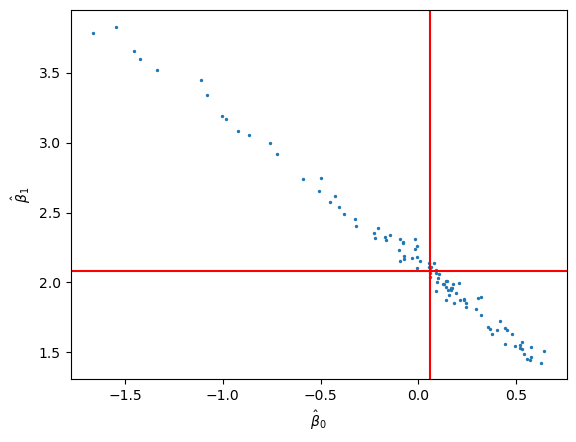

In [48]:
plt.scatter(bsim[id_valid,-1,0],bsim[id_valid,-1,1], s=2)
plt.axhline(y=beta[1], color='red')
plt.axvline(x=beta[0], color='red')
plt.xlabel(r"$\hat{\beta}_0$"); plt.ylabel(r"$\hat{\beta}_1$")

In [49]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[0,0])

0.5172730988568931

In [50]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[1,1])

0.5572103632685669

In [51]:
np.cov(bsim[id_valid,-1,:].T)

array([[ 0.26757146, -0.28680952],
       [-0.28680952,  0.31048339]])

In [52]:
Rsim = np.zeros([T+T0,np.sum(id_valid)])
for t in np.arange(T+T0):
    Rsim[t] = K / (1 + np.exp(bsim[id_valid,-1,:] @ A[t]))

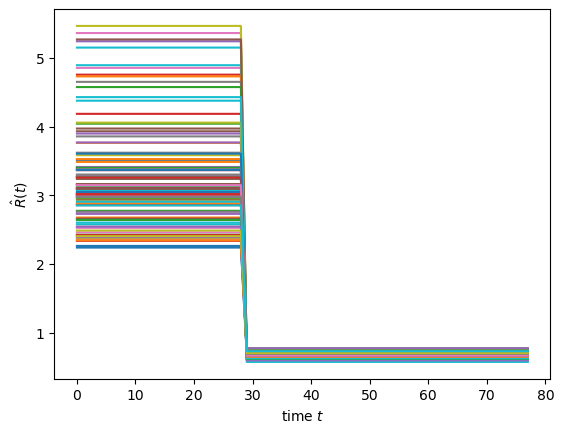

In [53]:
plt.plot(Rsim)
plt.xlabel(r"time $t$"); plt.ylabel(r"$\hat{R}(t)$")
plt.show()

# save and load

In [388]:
# np.savez("result_parametric_zero_s_eta.npz",
#          mmle_0 = mmle_0, smle_eps = smle_eps, bmle = bmle,
#          mhs_0 = mhs_0, shs_eps = shs_eps, bhs = bhs,
#          msim_0 = msim_0, ssim_eps = ssim_eps, bsim = bsim,
#          I_sim = I_sim, Ys_sim = Ys_sim)

In [20]:
locals().update(np.load("result_parametric_zero_s_eta.npz"))